#Fine tuning LLM model

In [14]:
!pip install -q -U bitsandbytes #for reducing floating bits size of training parameters
# !pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install transformers==4.31
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install evaluate
!pip install -qqq trl==0.7.1 #helpful library for fine tuning llm for both supervised and rlhf fine tuning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [15]:
import torch
import time
import evaluate
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import random

In [16]:
df=pd.read_excel("final_data.xlsx")

df.head()

,Unnamed: 0,Node,Deviation,Cause,Consequence,HPL Risk Matrix-S,HPL Risk Matrix-L,HPL Risk Matrix-RR,Effective Safeguards,Recommendations
0,0.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,1.More Flow of Feed,1.Human error - Battery limit Valve left open during Recirculation Mode (Valve FV-11101 Down stream),"1.Level increases in the rerun column with subsequent rise in pressure in the system beyond design pressure. Leak of Benzene with potential for fire, fatality and asset damage.",4.0,1.0,4A,1.FIC-11101 will give high Flow Alarm,1.Consider providing low temperature alarm on TI-11151
1,28.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,1.Tube rupture of Feed preheater 5E-01N,"1.NMP will enter HC side, process upset, increase in temperature",2.0,1.0,2A,1.Feed Preheater designed for a pressure of 20 kg / cm2 and it is operated at 6 kg / cm2,2.Consider providing high temperature alarm on TI-11151
2,29.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,1.Tube rupture of Feed preheater 5E-01N,"1.NMP will enter HC side, process upset, increase in temperature",2.0,1.0,2A,2.TIC-11352 will give high temperature alarm and regulate the 3way Control Valve,2.Consider providing high temperature alarm on TI-11152
3,30.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,2.Tube rupture of NMP reboiler 5E-02,"1.NMP will enter HC side, process upset, increase in Column bottom temperature",2.0,1.0,2A,1.NMP Reboiler designed for a pressure of 4 kg / cm2 and it is operated at 0.4 kg/ cm2,2.Consider providing high temperature alarm on TI-11153
4,31.0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,2.Tube rupture of NMP reboiler 5E-02,"1.NMP will enter HC side, process upset, increase in Column bottom temperature",2.0,1.0,2A,2.TIC-11111 (steam) will give high temperature alarm,2.Consider providing high temperature alarm on TI-11154


In [17]:
df=df.iloc[:,1:]
df.head()

,Node,Deviation,Cause,Consequence,HPL Risk Matrix-S,HPL Risk Matrix-L,HPL Risk Matrix-RR,Effective Safeguards,Recommendations
0,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,1.More Flow of Feed,1.Human error - Battery limit Valve left open during Recirculation Mode (Valve FV-11101 Down stream),"1.Level increases in the rerun column with subsequent rise in pressure in the system beyond design pressure. Leak of Benzene with potential for fire, fatality and asset damage.",4.0,1.0,4A,1.FIC-11101 will give high Flow Alarm,1.Consider providing low temperature alarm on TI-11151
1,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,1.Tube rupture of Feed preheater 5E-01N,"1.NMP will enter HC side, process upset, increase in temperature",2.0,1.0,2A,1.Feed Preheater designed for a pressure of 20 kg / cm2 and it is operated at 6 kg / cm2,2.Consider providing high temperature alarm on TI-11151
2,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,1.Tube rupture of Feed preheater 5E-01N,"1.NMP will enter HC side, process upset, increase in temperature",2.0,1.0,2A,2.TIC-11352 will give high temperature alarm and regulate the 3way Control Valve,2.Consider providing high temperature alarm on TI-11152
3,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,2.Tube rupture of NMP reboiler 5E-02,"1.NMP will enter HC side, process upset, increase in Column bottom temperature",2.0,1.0,2A,1.NMP Reboiler designed for a pressure of 4 kg / cm2 and it is operated at 0.4 kg/ cm2,2.Consider providing high temperature alarm on TI-11153
4,1. Feed C6 to Rerun Column 5C-01R and NMP & Steam Reboiler 5E-02 & 5E-03N via Feed preheater 5E-01N,3.Misdirected Flow,2.Tube rupture of NMP reboiler 5E-02,"1.NMP will enter HC side, process upset, increase in Column bottom temperature",2.0,1.0,2A,2.TIC-11111 (steam) will give high temperature alarm,2.Consider providing high temperature alarm on TI-11154


Data preprocessing

In [18]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [62]:
# For deviations


def text_cleaner(text):
    # Lowercase the text
    newString = text.lower()

    # Remove HTML tags
    newString = BeautifulSoup(newString, "lxml").text

    # Remove double quotation marks
    newString = re.sub('"', '', newString)

    # Replace "/" with "or"
    newString = re.sub("/", " or ", newString)
    newString=newString.strip()

    # Remove unwanted characters
    newString = re.sub(r":|-|_", " ", newString)

    # Remove leading numbers followed by a period and optional whitespace OR directly by text
    newString = re.sub(r"^\d+(\.|\b)", "", newString)

    # Remove special characters
    newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

    # Tokenize the cleaned text and remove stop words
    tokens = [w for w in newString.split()]

    # Remove extra spaces and join the tokens
    words = [i for i in tokens if len(i) >= 1]

    # Join the words and strip leading/trailing spaces
    return " ".join(words).strip()


Deviation_text = []
for t in df['Deviation']:
    Deviation_text.append(text_cleaner(t))

df['Deviation']=Deviation_text

In [63]:
# For Node


def text_cleaner(text):
    # Lowercase the text
    newString = text.lower()

    # Remove HTML tags
    newString = BeautifulSoup(newString, "lxml").text

    # Remove double quotation marks
    newString = re.sub('"', '', newString)

    # Replace "/" with "or"
    newString = re.sub("/", " ", newString)
    newString=newString.strip()

    # Remove unwanted characters
    newString = re.sub(r":|-|_", " ", newString)

    # Remove leading numbers followed by a period and optional whitespace OR directly by text
    newString = re.sub(r"^\d+(\.|\b)", "", newString)

    # Remove special characters
    newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

    # Tokenize the cleaned text and remove stop words
    tokens = [w for w in newString.split()]

    # Remove extra spaces and join the tokens
    words = [i for i in tokens if len(i) >= 1]

    # Join the words and strip leading/trailing spaces
    return " ".join(words).strip()


Node_text = []
for t in df['Node']:
    Node_text.append(text_cleaner(t))

df['Node']=Node_text

In [64]:
# For Cause


def text_cleaner(text):
    # Lowercase the text
    newString = text.lower()

    # Remove HTML tags
    newString = BeautifulSoup(newString, "lxml").text

    # Remove double quotation marks
    newString = re.sub('"', '', newString)

    # Replace "/" with "or"
    newString = re.sub("/", " ", newString)
    newString=newString.strip()

    # Remove unwanted characters
    newString = re.sub(r":|-|_", " ", newString)

    # Remove leading numbers followed by a period and optional whitespace OR directly by text
    newString = re.sub(r"^\d+(\.|\b)", "", newString)

    # Remove special characters
    newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

    # Tokenize the cleaned text and remove stop words
    tokens = [w for w in newString.split()]

    # Remove extra spaces and join the tokens
    words = [i for i in tokens if len(i) >= 1]

    # Join the words and strip leading/trailing spaces
    return " ".join(words).strip()


Cause_text = []
for t in df['Cause']:
    Cause_text.append(text_cleaner(t))

df['Cause']=Cause_text

In [65]:
# For Consequence


def text_cleaner(text):
    if isinstance(text, str):  # Check if text is a valid string
        # Lowercase the text
        newString = text.lower()

        # Remove HTML tags
        newString = BeautifulSoup(newString, "lxml").text

        # Remove double quotation marks
        newString = re.sub('"', '', newString)

        # Replace "/" with "or"
        newString = re.sub("/", " ", newString)
        newString=newString.strip()

        # Remove unwanted characters
        newString = re.sub(r":|-|_", " ", newString)

        # Remove leading numbers followed by a period and optional whitespace OR directly by text
        newString = re.sub(r"^\d+(\.|\b)", "", newString)

        # Remove special characters
        newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

        # Tokenize the cleaned text and remove stop words
        tokens = [w for w in newString.split() if not w in stop_words]

        # Remove extra spaces and join the tokens
        words = [i for i in tokens if len(i) >= 1]

        # Join the words and strip leading/trailing spaces
        return " ".join(words).strip()
    else:
        return "none"


Consequence_text = []
for t in df['Consequence']:
    Consequence_text.append(text_cleaner(t))

df['Consequence']=Consequence_text

In [66]:
# For Effective Safeguards

def text_cleaner(text):
    if isinstance(text, str):  # Check if text is a valid string
        # Lowercase the text
        newString = text.lower()

        # Remove HTML tags
        newString = BeautifulSoup(newString, "lxml").text

        # Remove double quotation marks
        newString = re.sub('"', '', newString)

        # Replace "/" with "or"
        newString = re.sub("/", " ", newString)
        newString=newString.strip()

        # Remove unwanted characters
        newString = re.sub(r":|-|_", " ", newString)

        # Remove leading numbers followed by a period and optional whitespace OR directly by text
        newString = re.sub(r"^\d+(\.|\b)", "", newString)

        # Remove special characters
        newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

        # Tokenize the cleaned text and remove stop words
        tokens = [w for w in newString.split() if not w in stop_words]

        # Remove extra spaces and join the tokens
        words = [i for i in tokens if len(i) >= 1]

        # Join the words and strip leading/trailing spaces
        return " ".join(words).strip()
    else:
        return "none"


ES_text = []
for t in df['Effective Safeguards']:
    ES_text.append(text_cleaner(t))

df['Effective Safeguards']=ES_text

In [67]:
# For Recommendations


def text_cleaner(text):
    # Lowercase the text
    newString = text.lower()

    # Remove HTML tags
    newString = BeautifulSoup(newString, "lxml").text

    # Remove double quotation marks
    newString = re.sub('"', '', newString)

    # Replace "/" with "or"
    newString = re.sub("/", " or ", newString)
    newString=newString.strip()

    # Remove unwanted characters
    newString = re.sub(r":|-|_", " ", newString)

    # Remove leading numbers followed by a period and optional whitespace OR directly by text
    newString = re.sub(r"^\d+(\.|\b)", "", newString)

    # Remove special characters
    newString = re.sub(r"[$#@%&*!~?%{}()]", " ", newString)

    # Tokenize the cleaned text and remove stop words
    tokens = [w for w in newString.split()]

    # Remove extra spaces and join the tokens
    words = [i for i in tokens if len(i) >= 1]

    # Join the words and strip leading/trailing spaces
    return " ".join(words).strip()


Recommendations_text = []
for t in df['Recommendations']:
    Recommendations_text.append(text_cleaner(t))

df['Recommendations']=Recommendations_text
df.head()

,Node,Deviation,Cause,Consequence,HPL Risk Matrix-S,HPL Risk Matrix-L,HPL Risk Matrix-RR,Effective Safeguards,Recommendations
0,feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,more flow of feed,human error battery limit valve left open during recirculation mode valve fv 11101 down stream,"level increases rerun column subsequent rise pressure system beyond design pressure. leak benzene potential fire, fatality asset damage.",4.0,1.0,4A,fic 11101 give high flow alarm,consider providing low temperature alarm on ti 11151
1,feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,misdirected flow,tube rupture of feed preheater 5e 01n,"nmp enter hc side, process upset, increase temperature",2.0,1.0,2A,feed preheater designed pressure 20 kg cm2 operated 6 kg cm2,consider providing high temperature alarm on ti 11151
2,feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,misdirected flow,tube rupture of feed preheater 5e 01n,"nmp enter hc side, process upset, increase temperature",2.0,1.0,2A,tic 11352 give high temperature alarm regulate 3way control valve,consider providing high temperature alarm on ti 11152
3,feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,misdirected flow,tube rupture of nmp reboiler 5e 02,"nmp enter hc side, process upset, increase column bottom temperature",2.0,1.0,2A,nmp reboiler designed pressure 4 kg cm2 operated 0.4 kg cm2,consider providing high temperature alarm on ti 11153
4,feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n,misdirected flow,tube rupture of nmp reboiler 5e 02,"nmp enter hc side, process upset, increase column bottom temperature",2.0,1.0,2A,tic 11111 steam give high temperature alarm,consider providing high temperature alarm on ti 11154


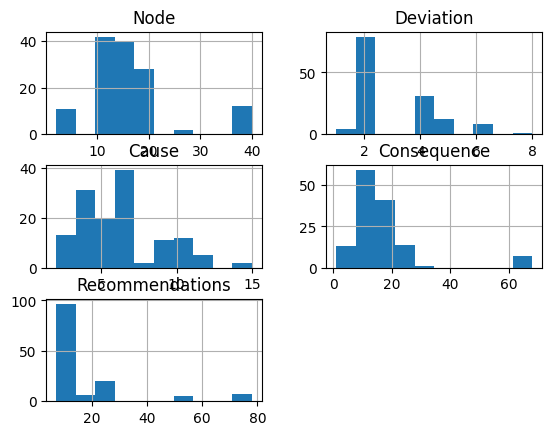

In [70]:

import matplotlib.pyplot as plt
node_count=[]
deviation_count=[]
cause_count=[]
consequence_count	=[]
es_count=[]
Recommendations_count=[]

# populate the lists with sentence lengths
for i in df['Node']:
      node_count.append(len(i.split()))

for i in df['Deviation']:
      deviation_count.append(len(i.split()))
for i in df['Cause']:
      cause_count.append(len(i.split()))
for i in df['Consequence']:
      consequence_count.append(len(i.split()))
for i in df['Effective Safeguards']:
      es_count.append(len(i.split()))
for i in df['Recommendations']:
      Recommendations_count.append(len(i.split()))

length_df = pd.DataFrame({'Node':node_count, 'Deviation':deviation_count,'Cause':cause_count,'Consequence':consequence_count,'Recommendations':Recommendations_count})
length_df.hist(bins = 10)
plt.show()

In [71]:
print(max(node_count),max(deviation_count),max(cause_count),max(consequence_count),max(es_count),max(Recommendations_count))

40 8 15 68 17 78


In [72]:
# Concatenating the columns
df['question'] = df.apply(lambda row: f"what is the recommendations when Node is {row['Node']}, Deviation is {row['Deviation']}, Cause is {row['Cause']}, Consequence is {row['Consequence']}, HPL Risk Matrix-S is {row['HPL Risk Matrix-S']}, HPL Risk Matrix-L is {row['HPL Risk Matrix-L']}, HPL Risk Matrix-RR is {row['HPL Risk Matrix-RR']} and Effective Safeguards is {row['Effective Safeguards']}?", axis=1)

# Drop the original columns
df.drop(columns=['Node', 'Deviation', 'Cause', 'Consequence','HPL Risk Matrix-S','HPL Risk Matrix-L','HPL Risk Matrix-RR','Effective Safeguards'], inplace=True)

In [73]:
df.head()

,Recommendations,question
0,consider providing low temperature alarm on ti 11151,"what is the recommendations when Node is feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n, Deviation is more flow of feed, Cause is human error battery ..."
1,consider providing high temperature alarm on ti 11151,"what is the recommendations when Node is feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n, Deviation is misdirected flow, Cause is tube rupture of feed ..."
2,consider providing high temperature alarm on ti 11152,"what is the recommendations when Node is feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n, Deviation is misdirected flow, Cause is tube rupture of feed ..."
3,consider providing high temperature alarm on ti 11153,"what is the recommendations when Node is feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n, Deviation is misdirected flow, Cause is tube rupture of nmp r..."
4,consider providing high temperature alarm on ti 11154,"what is the recommendations when Node is feed c6 to rerun column 5c 01r and nmp steam reboiler 5e 02 5e 03n via feed preheater 5e 01n, Deviation is misdirected flow, Cause is tube rupture of nmp r..."


In [83]:
from sklearn.model_selection import train_test_split
question,x_val,recommendations,y_val=train_test_split(df['question'],df['Recommendations'],test_size=0.05,random_state=0,shuffle=True)

In [84]:
question.head()

104    what is the recommendations when Node is primary nmp loop nmp from raffinate column 5c 03r to ed column 5c 02r, Deviation is more flow in ed columns, Cause is fv 41351 inadvertently open, Conseque...
22     what is the recommendations when Node is residue c6 from rerun column 5c 01n to suction of bottoms pump 5p 01 a b to pghu and e1, Deviation is less or no flow, Cause is fy 11104 inadvertently stuc...
113    what is the recommendations when Node is benzene from reflux drum 5v 03r to column 5c 04r as reflux and as product to osbl, Deviation is more flow, Cause is fic 42115 inadvertently open, Consequen...
48     what is the recommendations when Node is raffinate from reflux drum 5v 02r to 5c 03 r p, Deviation is more flow, Cause is fic 31112 inadvertently open more flow to 5c 03r, Consequence is decrease ...
97     what is the recommendations when Node is primary nmp loop nmp from raffinate column 5c 03r to ed column 5c 02r, Deviation is more flow in ed columns, Cause is fv 413

In [85]:
question=list(question)
test_question=list(x_val)
recommendations=list(recommendations)
target=list(y_val)

In [91]:
len(question),len(test_question)

(128, 7)

In [92]:
from datasets import DatasetDict, Dataset

# Create DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_dict({'question': question, 'recommendations': recommendations}),
    'test': Dataset.from_dict({'question': test_question, 'recommendations': target})
})

# Print dataset info
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['question', 'recommendations'],
        num_rows: 128
    })
    test: Dataset({
        features: ['question', 'recommendations'],
        num_rows: 7
    })
})


In [93]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [94]:
len(dataset['train'])

128

In [95]:
def format_instruction(question: str, recommendations: str):
	return f"""### Instruction:
Answer the following question

### Input:
{question.strip()}

### Answer:
{recommendations}
""".strip()


In [96]:
def generate_instruction_dataset(data_point):

    return {
        "question": data_point["question"],
        "recommendations": data_point["recommendations"],
        "text": format_instruction(data_point["question"],data_point["recommendations"])
    }

In [97]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42)
        .map(generate_instruction_dataset)
    )

In [98]:
sample_dataset = dataset.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7 [00:00<?, ? examples/s]

In [99]:
type(sample_dataset)

datasets.dataset_dict.DatasetDict

In [100]:
sample_dataset["train"] = process_dataset(sample_dataset["train"])
sample_dataset["test"] = process_dataset(sample_dataset["test"])

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [101]:
## APPLYING PREPROCESSING ON WHOLE DATASET
dataset["train"] = process_dataset(dataset["train"])
dataset["test"] = process_dataset(dataset["test"])

train_data = dataset['train'].shuffle(seed=42).select([i for i in range(110)])
# Select 10 rows for the test
test_data = dataset['test']
validation_data = dataset['train'].shuffle(seed=42).select([i for i in range(20)])

train_data,test_data,validation_data

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

(Dataset({
     features: ['question', 'recommendations', 'text'],
     num_rows: 110
 }),
 Dataset({
     features: ['question', 'recommendations', 'text'],
     num_rows: 7
 }),
 Dataset({
     features: ['question', 'recommendations', 'text'],
     num_rows: 20
 }))

In [102]:
train_data['question'][0]

'what is the recommendations when Node is secondarynmp loop nmp from benzene stripper column 5c 04r to fd column 5c 02r through reboiler 5e 05 5e 02 and feed preheater 5e 01n, Deviation is less or no flow, Cause is ly 31107 inadvertently closes, Consequence is 5c 02r temperature increases,minor decrease level, process upset, HPL Risk Matrix-S is 1.0, HPL Risk Matrix-L is 1.0, HPL Risk Matrix-RR is 1A and Effective Safeguards is ti 21153 21352 give high temperature alarm?'

In [103]:
sample_dataset["train"]["text"][0]

'### Instruction:\nAnswer the following question\n\n### Input:\nwhat is the recommendations when Node is raffinate from reflux drum 5v 02r to 5c 03 r p, Deviation is less or no flow, Cause is fic 22153 inadvertently closed less flow to 5c 02p, Consequence is decrease 5c 02r temperature, less flow 5c 02p 5c 03r, process upset, major consequences, HPL Risk Matrix-S is 1.0, HPL Risk Matrix-L is 1.0, HPL Risk Matrix-RR is 1A and Effective Safeguards is ti 31128 give low temperature alarm?\n\n### Answer:\nconsider providing high temperature alarm on ti 31130'

In [104]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id =  "NousResearch/Llama-2-7b-hf" #this is not a chat model but a base model it wont have understanding of promts and commands, it just generate
# model_id = "meta-llama/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


ValueError: 
                        Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit
                        the quantized model. If you want to dispatch the model on the CPU or the disk while keeping
                        these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom
                        `device_map` to `from_pretrained`. Check
                        https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu
                        for more details.
                        

## ZERO-SHOT INFERENCE WITH LLAMA-2 7B
we are using base model to write summary

In [151]:
index = 0

question = question[index]
recommendations = recommendations[index]

prompt = f"""
Answer the following Question.

### Input:
{question}

### answer:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=100,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN Answer:\n{recommendations}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

### Input:
british tourist drowned pool luxury villa spain, hours arriving holiday. brian nicol, , dived swimming pool luxury holiday villa costa del sol, staying friends, failed resurface. desperate friends dragged mr nicol, born glasgow, water tried save him. brian nicol, glasgow, scotland, died staying villa nueva andalucia like one pictured . police paramedics arrived shortly incident took place around . easter sunday morning, mr nicol died. officers said early evidence suggests death tragic accident, try establish whether suffered blow head digestion problems meant could swim. group night marbella jetting spain saturday, returning rented villa nueva andalucia carry partying around pool. post mortem due take place monday morning malaga forensic medicine institute. police spokesman said 'the incident still investigated evidence sta

# Training Setup

Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [152]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():

        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [153]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [154]:

print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [155]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(

    # r stands number of rank decomposition matrix (higher rank leads better results but high computations)
    r=16,

    lora_alpha=64, # scaling factor, determines the extend t0 which the model is adapted towards new training data  (lower value gives more weightage to the original data or biased towards baise model)

    # target_modules=["query_key_value"],

    #specific to Llama models. here we can determines which specific weights and matrices are to be trained (most basic are to train qeury and value vectors)
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], #here o_proj is for output

    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

trainable params: 16777216 || all params: 3517190144 || trainable%: 0.477006226934315


# Training

In [ ]:
OUTPUT_DIR = "llama2-docsum-adapter"

In [157]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit", #a special type of adam optimizer used for training llm models
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [ ]:
from trl import SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=validation_data,
    peft_config=lora_config,
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
)

trainer.train()

Map:   0%|          | 0/9190 [00:00<?, ? examples/s]

Map:   0%|          | 0/2298 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


In [ ]:
peft_model_path="./peft-dialogue-summary"

trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-dialogue-summary/tokenizer_config.json',
 './peft-dialogue-summary/special_tokens_map.json',
 './peft-dialogue-summary/tokenizer.model',
 './peft-dialogue-summary/added_tokens.json',
 './peft-dialogue-summary/tokenizer.json')

# Inference

In [ ]:
from transformers import TextStreamer
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

peft_model_dir = "peft-dialogue-summary"

# load base LLM model and tokenizer
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(peft_model_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
index = 0

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

### Input:
{dialogue}

### Summary:
"""

input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
# output = tokenizer.decode(
#     trained_model.generate(
#         inputs_ids,
#         max_new_tokens=100,
#     )[0],
#     skip_special_tokens=True
# )
outputs = trained_model.generate(input_ids=input_ids, max_new_tokens=100, )
output= tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'TRAINED MODEL GENERATED TEXT :\n{output}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

### Input:
#Person1#: Did you enjoy your weekend at the highland hotel? I heard it's and excellent place to stay and has good facilities.
#Person2#: I had a wonderful time. The rooms are not very big, but they are well furnished. The restaurant is excellent and reasonably priced. There's a sauna and a Jacuzzi.
#Person1#: Do they have a swimming pool?
#Person2#: No, they don't. they have a beauty parlor, but I didn't go there.
#Person1#: What's the service like?
#Person2#: It's very good. Check in and check out at the reception only took a few minutes. The wait staff is very good. A waiter recommended their baked fish, which tasted wonderful. The hotel was quite full, so I'd suggest making a reservation if you intend to go there. The hotel offers a discount at the weekends.
#Person1#: It sounds perfect. Did you have any complaints at a

# Merge Trained LoRA Adapter With BASE MODEL and Push Model to Hub

---



In [ ]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)
# Merge LoRA and base model
merged_model = trained_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")

# push merged model to the hub
# merged_model.push_to_hub("user/repo")
# tokenizer.push_to_hub("user/repo")

NameError: name 'AutoPeftModelForCausalLM' is not defined